# EDA(探索的データ分析)
【目的】  
- 従業員データから離職傾向・データの全体像・特徴同士の関係性・問題点・欠損値・異常値を可視化し把握する。  
【理由】  
- モデルに与える説明変数を決めることで、誤った予測にならないようにする。
- モデルが出した結果について背景を考察できることで、「なぜそうなったのか」分析して説明することができる。
- 仮説や分析プランを立てやすくなり、効率的な分析やモデル設計が可能になる。


| レベル    | 内容                              | 分析手法           |
| :----- | :------------------------------ | :------------- |
| ① 結果   | 女性が多い部署で離職率が高い                  | モデル・集計         |
| ② 背景   | 部署構成上、女性が多い職種で負担が大きい            | EDA（クロス集計など）   |
| ③ 要因仮説 | 業務内容や育児・介護との両立が難しいなど、性別特有の要因がある | 外部知見・現場ヒアリングなど |


### 〇　Step1: 「会社全体でどのくらいの人が退職しているか」を掴む。
【目的】  
- 「会社全体でどのくらいの人が退職しているか」を掴む。
⇒ 在職者と退職者の割合見る。  
【理由】  
- 不均衡なまま学習したら、モデルが「ACTIVE」と予測しておけばほとんど当たる。
精度上は高く見えるけど、退職者全然見つけられない「役に立たないモデル」になる。

【具体策】  
-  value_counts()で在職者と退職者の数を集計して、それをもとに棒グラフに変換！<br>
df["STATUS"].value_counts().plot(kind="bar")


【結果】
- 97%が在職者、3%が退職者。退職者を正確に予測することが目的であるため、モデルの評価はaccuracyではなく他の指標で予測精度を図る必要があるとわかった。（ recall,AUCを見る。）


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
df = pd.read_csv("data/raw/MFG10YearTerminationData.csv")

STATUS
ACTIVE        48168
TERMINATED     1485
Name: count, dtype: int64


(array([0, 1]), [Text(0, 0, 'ACTIVE'), Text(1, 0, 'TERMINATED')])

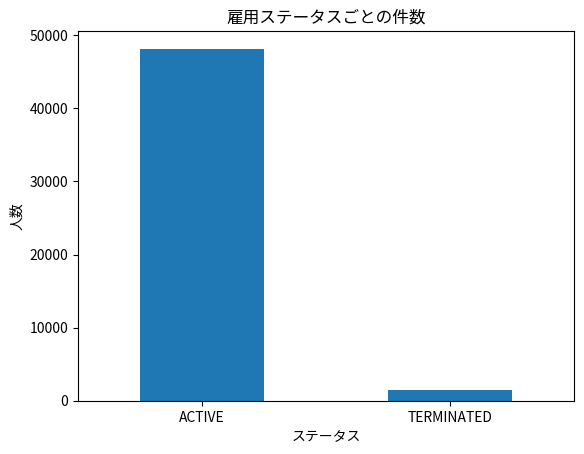

In [3]:
print(df["STATUS"].value_counts())
df["STATUS"].value_counts().plot(kind = "bar")


""""""
plt.title("雇用ステータスごとの件数")
plt.xlabel("ステータス")
plt.ylabel("人数")
plt.xticks(rotation=0)

In [4]:
df["STATUS"].value_counts(normalize =True)

# 全体の２パーセントしか退職者がいない。予測したいので、accuracyではなく他の指標で予測精度を図る必要があるとわかった。


STATUS
ACTIVE        0.970092
TERMINATED    0.029908
Name: proportion, dtype: float64

### 〇　step2 部門ごとの離職傾向
##### 【目的】
- 部門によって退職率が偏っていないかを確認する。  
##### 【理由】  
- 部門によって退職率変わるなら、退職に影響を与える特徴として説明変数として利用する。<br>
##### 【具体策】
- クロスタブを使えば、部署ごとの退職率を比率で表せる。
- pd.crosstab(df["department_name"], df["STATUS"], normalize="index") * 100

##### 【結果】
- 部門ごとに離職率の差が見受けられた。離職に影響がある要因と考え、説明変数として利用。
    - IT部門が離職率トップだが人数は少な目。転職多い業界特性関係？
    - 少人数だが、laborRelations,legal,compensation,auditなどが比較的高い。本社機能全体で傾向ありそう？
    - store部門は、離職率低い。

##### １．本社機能と店舗ごとの人数

BUSINESS_UNIT
STORES        0.988218
HEADOFFICE    0.011782
Name: proportion, dtype: float64


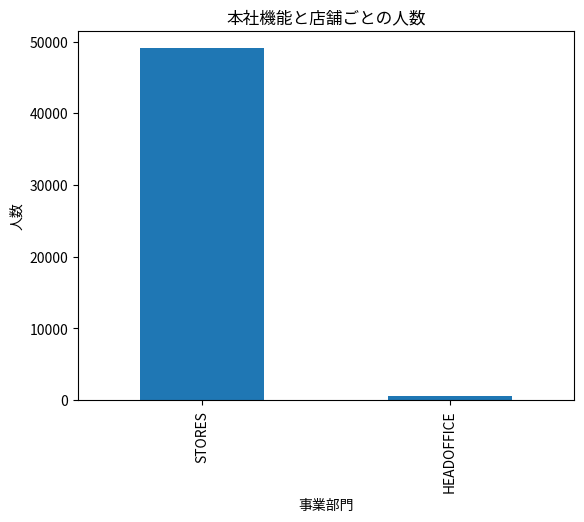

In [5]:
print(df["BUSINESS_UNIT"].value_counts(normalize =True))
df["BUSINESS_UNIT"].value_counts().plot(kind ='bar')

plt.title('本社機能と店舗ごとの人数')
plt.xlabel('事業部門')
plt.ylabel("人数")
plt.show()

#現場の人数が圧倒的に大きい。
#本社機能は、コンパクト
##【推測】店舗展開型ビジネスで大規模小売（コンビニ、スーパー、アパレルチェーン）本社は、企画や戦略がメインで店舗が実働部隊。

##### ２.部門ごとの人数の割合

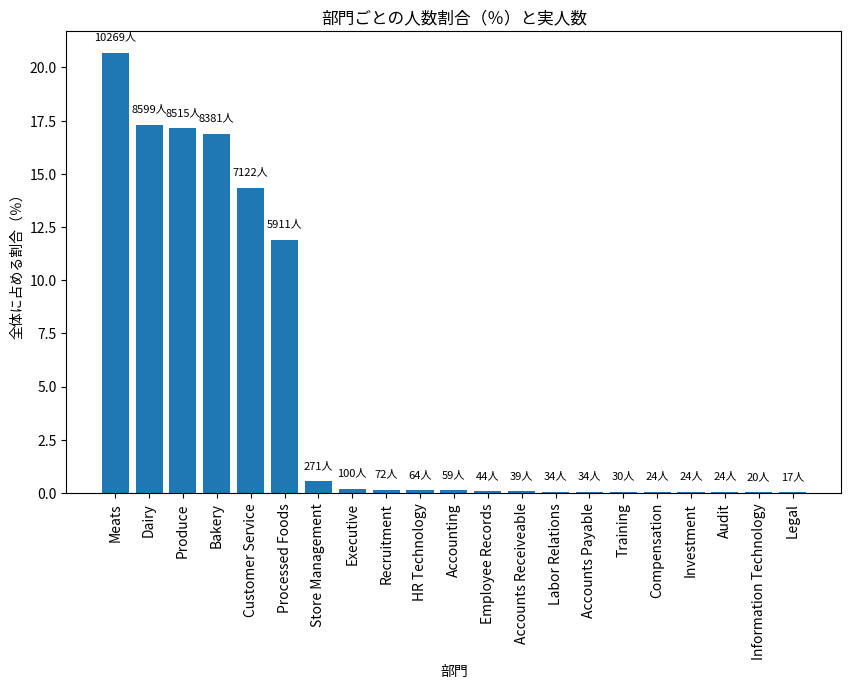

In [6]:
# 部門ごとの人数と割合を計算
dep_counts = df['department_name'].value_counts()
dep_ratio = dep_counts / dep_counts.sum() * 100

plt.figure(figsize=(10,6))
bars = plt.bar(dep_ratio.index, dep_ratio.values)

plt.title("部門ごとの人数割合（％）と実人数")
plt.ylabel("全体に占める割合（％）")
plt.xlabel("部門")
plt.xticks(rotation=90)

# 棒の上に「人数」を表示
for bar, count in zip(bars, dep_counts):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.5,   # 棒の少し上に表示
        f"{count}人",
        ha='center', va='bottom', fontsize=8
    )

plt.show()


#### ３．部門ごとの退職者の比率

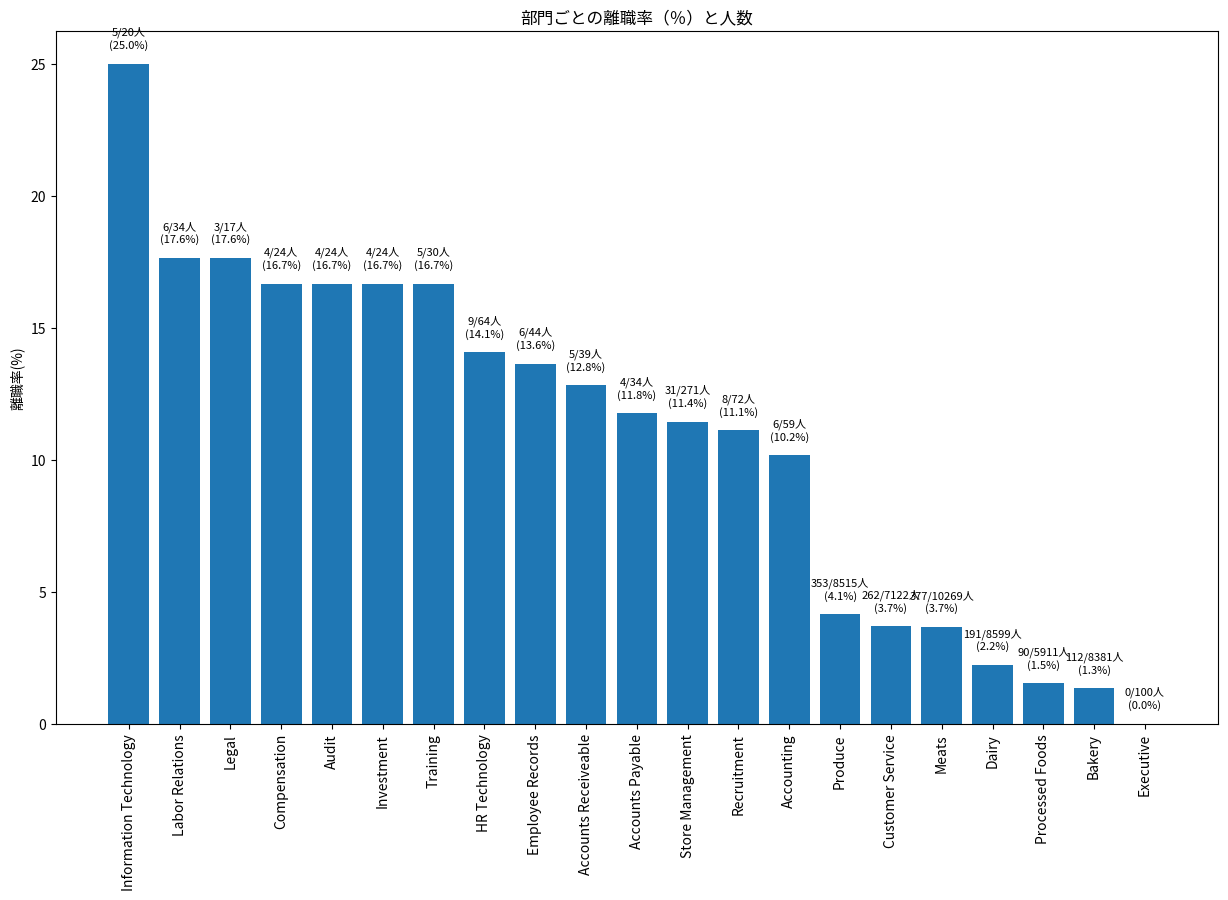

In [7]:
#①離職率計算（各部門ごとの在職者と離職者の比率出す）
status_ratio = pd.crosstab(df["department_name"],df["STATUS"],normalize ="index")*100

#②離職率高い順に並べる
sorted_index = status_ratio["TERMINATED"].sort_values(ascending=False).index
status_ratio_sorted = status_ratio.loc[sorted_index]

#③棒グラフ　+ 注釈ラベル追加
plt.figure(figsize=(15,9))
bars = plt.bar(status_ratio_sorted.index, status_ratio_sorted["TERMINATED"])
plt.title("部門ごとの離職率（％）と人数")
plt.ylabel("離職率(%)")
plt.xticks(rotation =90)

#④　部門ごとの総人数と離職者を棒グラフの上に記載
for dept, bar in zip(status_ratio_sorted.index, bars):
    total = df[df["department_name"]==dept].shape[0]# 総人数
    term  = df[(df["department_name"]==dept) & (df["STATUS"]=='TERMINATED')].shape[0]# 離職者数
    rate = round(term / total * 100, 1)
    plt.text(bar.get_x() + bar.get_width()/2,bar.get_height() + 0.5,
            f"{term}/{total}人\n({rate}%)",
            ha= 'center',va ='bottom',fontsize =8)
    

#　IT部門が離職率トップだが人数は少な目。転職多い業界特性関係？
# 少人数だが、laborRelations,legal,compensation,auditなどが比較的高い。本社機能全体で傾向ありそう？
# store部門、離職率低い。

### 〇　step3.性別ごとの離職傾向

##### 【目的】
- 性別ごとに退職傾向が異なるか確認し、部署ごとの傾向と重ねて多面的に見る。
##### 【理由】
- 性別が離職の要因として説明変数に利用するか検討するため。
- 女性の退職率が高ければ、防止策として、育休・時短・配置配慮などの施策が有効と仮説として考えられるため。
##### 【具体策】
- 性別ごとの離職者の割合を確認し、性別ごとに辞めやすさがあるか傾向を見る。
- 離職者のみで男女の構成比を確認し、誰が辞めているのか・組織全体への影響の大きさを人数ベースで見る)
##### 【結果】
**〇離職率（辞めやすさ）**
- 男性の退職率：2.39%
 - 女性の退職率：3.53%  
⇒差は1.1%だけど、「女性の方が約48%多く退職している」(3.53 -2.39/2.39*100 =47.7)とも言えるため、
職場の改善策を考える上では無視できない差。  
「退職率そのものが低いから、1%の差でも無視できない」  

**〇離職者構成比（誰が辞めているか）**
- 男性:38.4%（570人）
- 女性:61.6% (915人)
⇒離職者全体の６割以上が女性で、実人数としても女性が目立つ。

In [32]:
# 性別別の離職率（辞めやすさ・傾向を比較）

# クロス集計表作成
gender_ratio = pd.crosstab(df["gender_short"], df["STATUS"]) 

gender_ratio = gender_ratio.rename(columns={"TERMINATED": "離職", "ACTIVE": "在職"},
                                   index= {"F": "女性", "M": "男性"})

# 離職率を追加
gender_ratio["離職率(%)"] = gender_ratio["離職"]/ gender_ratio.sum(axis=1) *100

gender_ratio

STATUS,在職,離職,離職率(%)
gender_short,,,
女性,24983,915,3.533091
男性,23185,570,2.399495


In [9]:
# 離職者のみ抽出して男女の構成比を確認(誰が辞めているのか・組織全体への影響の大きさを人数ベースで見る)
terminated = df[df["STATUS"] == "TERMINATED"]
terminated["gender_short"].value_counts(normalize=True) * 100



gender_short
F    61.616162
M    38.383838
Name: proportion, dtype: float64

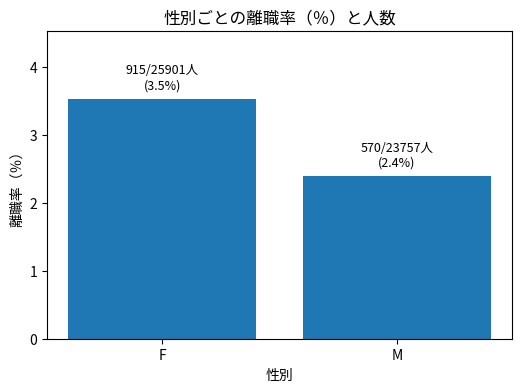

In [10]:
# 性別ごとのクロス集計表を作成
gender_count = pd.crosstab(df["gender_short"], df["STATUS"])

# 離職率（％）を追加
gender_count["離職率(%)"] = gender_count["TERMINATED"] / gender_count.sum(axis=1) * 100

# 性別ごとの値を取得
labels = gender_count.index
terminated = gender_count["TERMINATED"]
total = gender_count.sum(axis=1)
rate = gender_count["離職率(%)"]

# グラフを描く
plt.figure(figsize=(6,4))
bars = plt.bar(labels, rate)

plt.title("性別ごとの離職率（％）と人数")
plt.ylabel("離職率（％）")
plt.xlabel("性別")
plt.ylim(0, rate.max() + 1)  # 少し余白を追加
plt.xticks(rotation=0)

# 棒の上に「離職者数 / 総人数」を表示
for bar, t, n, r in zip(bars, terminated, total, rate):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.1,     # 少し上にずらす
        f"{int(t)}/{int(n)}人\n({r:.1f}%)",  # ←ここで全人数も表示！
        ha="center", va="bottom", fontsize=9
    )

plt.show()


###  〇step4. 部署と性別の関係

#### 【目的】
- 部署ごとの性別構成を可視化し、特定の部署に性別偏りがないか（例：男性が多い部署・女性が多い部署） を把握する。  
➡ 離職率の違いを分析する際に、性別の偏りが原因なのか、部署の文化なのかを区別できるようにするため。  

#### 【理由】
- 部署によって男女比が極端に異なる可能性がある。
この段階で性別と部署の関連性を把握しておくことで、

- 部署によって性別の構成比が大きく異なる場合、主要因は、部署の業務内容ではなかう、性別による影響がある。
  もし「男性が多い部署ほど離職率が高い」などの構造があるなら、離職要因を部署でなく性別の影響として解釈したほうが良い可能性。
- 部署構成の性別バランスを把握することで、後の因果関係分析の整理になる。後続のモデル解釈（特徴重要度など）がブレにくくなる。

    - パターン①：「部署差が原因」と思いきや、実は「性別差」だった
    「営業部は離職率が高い」
    → 実は営業部は男性が多く、男性が辞めやすい傾向がある
    → この場合、「性別の影響が大きい」と言える。

    - パターン②：逆に、「部署効果」そのものが強い場合もある
    例えば「女性が多い経理部」でも離職率が高い場合
    → 性別だけでは説明できない → 「部署の業務内容・負担・文化」の影響が強い



#### 【具体策】
- クロス集計表にて、各部署の男女比を%で作成
    - pd.crosstab(df["department_name"], df["gender_short"], normalize="index")
- 棒グラフにて、可視化
    - 女性比率が高い順に並べ、部署ごとの性別構成を視覚的に確認。
- カイ二乗検定（独立性の検定）
    - chi2_contingency()で「部署と性別の間に関連があるか」を統計的に確認。
    - 帰無仮説：部署と性別に関係はない。
    - 対立仮説：部署と性別には関係がある。


#### 【結果】
- カイ二乗統計量：413.85、p値：0.0000 < 0.05
　→ 帰無仮説を棄却。部署と性別の間には統計的に有意な関係があると判断。

- 部署ごとの傾向（可視化結果より）
　- IT・HR部門：男性比率が高い
　- 経理系・人事系：女性比率が高い
　- Store系（販売・製造部門）：男女比ほぼ半々

よって、「部署による離職率の差」を検討する際には、
　性別構成の偏りを考慮する必要があると結論づけた。


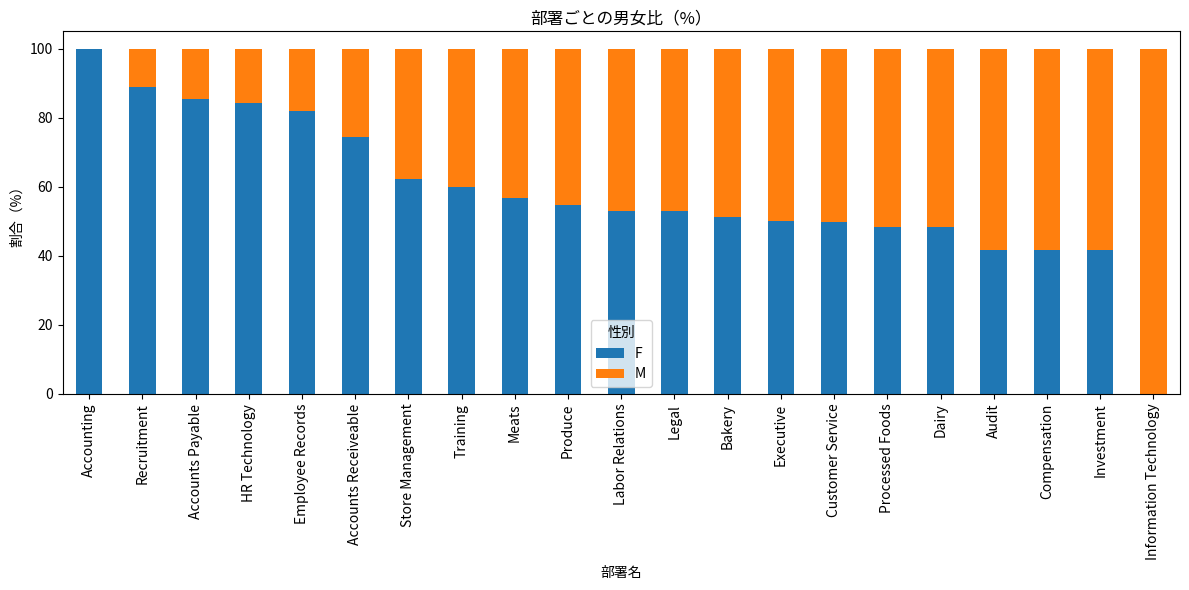

In [11]:
#①各部署×性別のクロス集計表を作る。
gender_by_dept = pd.crosstab(df["department_name"], df["gender_short"], normalize = "index")*100

#②女性比率が高い順に並べ替える
gender_by_dept_ratio = gender_by_dept["F"].sort_values(ascending= False) 

#③棒グラフで表示（女性比率が高い順に並べ替えた場合の特徴順を抽出すればできる。）
gender_by_dept.loc[gender_by_dept_ratio.index].plot(kind ="bar", stacked =True, figsize =(12,6))


plt.title("部署ごとの男女比（%）")
plt.ylabel("割合（%）")
plt.xlabel("部署名")
plt.xticks(rotation=90)
plt.legend(title="性別")
plt.tight_layout()#軸ラベルやタイトル、凡例などがはみ出したり、重なったりするのを防いで
plt.show()

# IT部門（Information Technology, HR Technology）は男性
# 経理系（Accounting系）やEmployee Records（人事）は女性比率が高い
# Compensation（報酬）やExecutive（経営）は男性比率が高め
# Store系部門（Meats, Produceなど）は男女比ほぼ半々

**カイ二乗検定（独立性の検定）にて、部署と性別に関連性があるか確かめる**   


In [12]:
from scipy.stats import chi2_contingency

table = pd.crosstab(df["department_name"], df["gender_short"])

chi2,p,dof,expected = chi2_contingency(table)

print(f"カイ二乗統計量: {chi2:.2f}")
print(f"p値: {p:.4f}")

カイ二乗統計量: 413.85
p値: 0.0000


### 〇 step5. 年齢によって、離職率をみる

##### 【目的】
- 「年齢層によって離職のしやすさに差があるか」を明らかにし、若年層の離職や定年層の離職など、構造的な傾向を把握することで、今後の特徴量設計や、人材定着施策の方向性を検討する。
##### 【理由】
- 離職の傾向を年齢別に把握することで、モデル作成時の特徴量（勤続年数、世代）や離職対策の方向性を検討するヒントになる。

##### 【具体策】
 年齢層と離職率の関係を統計的・可視的に分析するため、以下の手順を実施。
1. **年齢をカテゴリ化**：
    - `pd.cut()`を用いて「20代以下」「30代」「40代」「50代」「60代以上」にグループ化。
2. **カイ二乗検定**：
    - 「年齢層と離職率に関連があるか」を統計的に検証（有意水準5%）。
3. **標準化残差の算出**：
    - 各年代でどの傾向（離職が多い／少ない）が特に強いかを確認。
4. **クロス集計＋割合表示**：
    - 実際の離職率を％で算出し、数値的な実態と整合を確認。

##### 【結果】

#### 統計的結果
* カイ二乗統計量：5243.83
* p値：0.0000（< 0.05）  
  → 年齢層と離職率の間には**統計的に有意な関連**がある。

#### 標準化残差による傾向

| 年代	|実際の離職率	|標準化残差	|解釈|
|:---------|:----------------------|:-------------------------------------------------------|---|
|20代以下	|2.4%|	−3.2	|期待より離職が少ない（＝ 定年層の影響で全体平均が上昇している可能性,30~50代よりは多い。 ）|
|30〜50代	|0.5〜1.6%	|−8〜−15|	圧倒的に少ない、安定的に定着している層。特に特に40〜50代|
|60代以上	|20.4%|	＋67	|圧倒的に多い、定年要因の影響と考えられる。|

####  解釈
* 中堅層（30〜50代）は定着率が高く安定層。
* 60代は構造的要因（定年）による離職が多く、自然な年齢要因と考えられる。


####  まとめ
- 年代別に離職率を分析した結果、年齢層と離職傾向の間に有意な関連が確認された。
- 特に30〜50代は定着率が高く、長期在職の中心層である一方、20代以下は30〜50代よりも明らかに離職率が高い。
- 60代以上は定年退職による構造的離職が集中している。  

⇒この結果は、年齢構成の影響を考慮した特徴量設計（例：勤続年数・年代カテゴリ化）の必要性があると考えられる。

In [ ]:
# 年代カテゴリを作る。
bins = [0, 29, 39, 49, 59, 100]
labels = ['20代以下', '30代', '40代', '50代', '60代以上']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)
#pd.cutは数値データを区間【ビン）ごとに区切ってカテゴリ化する関数！！！
df["age_group"]

0          50代
1          50代
2          50代
3          50代
4          50代
         ...  
49648    20代以下
49649    20代以下
49650    20代以下
49651    20代以下
49652    20代以下
Name: age_group, Length: 49653, dtype: category
Categories (5, object): ['20代以下' < '30代' < '40代' < '50代' < '60代以上']

In [39]:
#　年代別の離職者の数と割合

age_ratio = pd.crosstab(df['age_group'], df['STATUS'])  # attritionが離職フラグの列（Yes/No）

age_ratio = age_ratio.rename(columns ={"TERMINATED":"離職", "ACTIVE":"在職"})

age_ratio["離職者率(%)"] = table["TERMINATED"] / table.sum(axis =1)*100

age_ratio

STATUS,在職,離職,離職者率(%)
age_group,,,
20代以下,9999,250,2.439262
30代,11489,186,1.593148
40代,11503,72,0.622030
50代,11608,62,0.531277
60代以上,3569,915,20.405888


In [15]:
# カイ二乗検定
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(table)

print(f"カイ二乗統計量: {chi2:.2f}")#小数点第２位まで
print(f"p値: {p:.4f}")  #小数点第４位まで
import numpy as np

#p値が0.0000（≪0.05）→ 「年代と離職には有意な関係がある」＝ 年代によって離職率が違う

カイ二乗統計量: 5243.83
p値: 0.0000


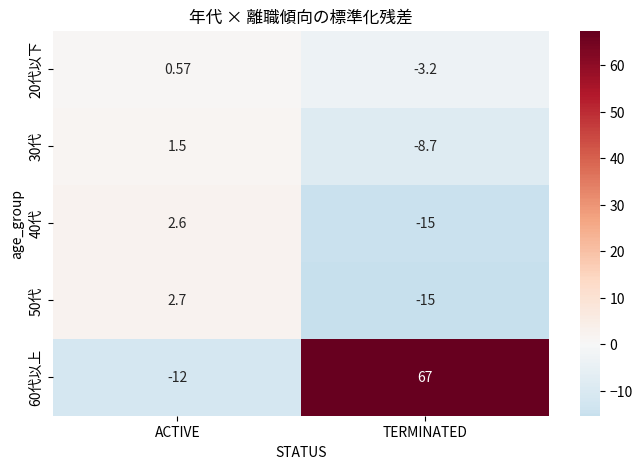

In [16]:
#標準化残差（std_resid）計算

import seaborn as sns
import matplotlib.pyplot as plt


std_resid = (table - expected) / np.sqrt(expected)


plt.figure(figsize=(8, 5))
sns.heatmap(std_resid, annot=True, cmap='RdBu_r', center=0)
plt.title("年代 × 離職傾向の標準化残差")
plt.show()

#→ 各セルごとに「実測値−理論値」を標準化。
# 値が ±1.96を超えると有意差あり（95%信頼区間）
# プラス（赤）＝多い（離職が多い）
# マイナス（青）＝少ない（離職が少ない）

#【結果】
# 

##### 標準化残差とは
「実際の観測数が、期待される数（＝偶然の範囲）からどれくらいズレているか」
を標準化した値のこと。
観測値(table) と 期待値(expected) のズレを
（標準偏差）で割って標準化している。

$$
標準化残差 =（観測値【実際の人数】 -期待値【期待人数】） / √期待値【期待人数】
$$	​

【目的】
- カイ二乗検定では「全体として関係があるか」しか分からない。
- 「どの年代が特に離職しやすい／しにくいか」までは分からない。
- 標準化残差を出すことで：
- ＋の値 → 期待より多い（離職多い）
- −の値 → 期待より少ない（離職少ない）	


|値| ≥ 1.96：統計的に有意な差がある（95%信頼水準）
|値| ≥ 2.58：より強い有意差（99%信頼水準）​




| 標準化残差の値     | 意味               | 解釈の目安                     |
| :---------- | :--------------- | :------------------------ |
| **0前後**     | 期待通り             | 「偶然の範囲内のズレ」。特に特徴なし。       |
| **+の値**     | 観測数 > 期待値        | そのセルで“多い”（例：想定より離職者が多い）   |
| **−の値**     | 観測数 < 期待値        | そのセルで“少ない”（例：想定より離職者が少ない） |
| **±1.96以上** | 有意な差（95%信頼水準）    | 「偶然では説明できないズレ」            |
| **±2.58以上** | より強い有意差（99%信頼水準） | 「明確な傾向」                   |


**Q.「0＝期待通り」とは？**

たとえば「年齢と離職が関係ない」と仮定したとき、
それぞれの年齢層の離職者数は、全体の平均割合に比例して分布するはず。

→ その“仮の分布”が「期待値」

実際の値＝期待値 ⇒ 残差＝0（＝想定どおり）

実際の値＞期待値 ⇒ 残差が＋（＝想定より多い）

実際の値＜期待値 ⇒ 残差が−（＝想定より少ない）

### 〇step6「性別 × 年代 × 離職」のクロス分析

#### 【目的】
- 性別ごとに年代別の離職率の傾向を見て、どの層が特に離職しやすいのかを確認する。
- 年代別の離職率分析で「60代が突出して離職率が高い」ことが分かったため、今回は性別との組み合わせによって、その傾向がさらに強まるかどうかを検証する。
- モデル構築前の段階で「交互作用（性別×年代）」の有無を把握しておくことが目的。（後で特徴量設計やダミー変数作成の参考になる）




#### 【具体策】
1. 年齢を5階級（20代以下、30代、40代、50代、60代以上）にカテゴリ化。
2. 離職ステータスをattrition_flag（在職=0／離職=1）として数値化。
3. pivot_tableで「性別×年代別の平均離職率」を算出。
4. seaborn.heatmapで離職率を可視化。明るい色ほど離職率が高い層を表す。

性別ごとに年代別の離職率の傾向を見て、どの層が離職しやすいのかを確認する。

部署や性別単体では見えなかった、“組み合わせによる特徴”を発見する。

モデル構築の前に「交互作用（性別×年代）」の存在を把握しておく。


おっけー！
ヒロのStep6（性別×年代×離職）めちゃくちゃいい締めだね。
ここまでの分析（Step4〜5）とちゃんと“つながる形”で書くと、
分析の流れとして一貫性が生まれて、ポートフォリオとしても一気に説得力が上がる✨

---

### 〇Step6 「性別 × 年代」で離職率を分析

#### 【目的】
性別ごとに年代別の離職率の傾向を見て、
どの層が特に離職しやすいのかを確認する。

#### 【理由】
Step4で「部署」と「性別」の関係を確認したところ、
部門によって男女比が偏っていることが分かった。
一方で、Step5では「年代」による離職率の違いが明確だった。
この2つを踏まえ、今回は**性別と年代を掛け合わせた場合に、
特定の層（例：若年女性・高齢男性など）が離職しやすいか**を確認する。

#### 【具体策】

1. 年齢を5階級（20代以下、30代、40代、50代、60代以上）にカテゴリ化。
2. 離職ステータスを`attrition_flag`（在職=0／離職=1）として数値化。
3. `pivot_table`で「性別×年代別の平均離職率」を算出。
4. `seaborn.heatmap`で離職率を可視化。* 明るい色ほど離職率が高い層を表す。


### 【結果】

| 年代     | 女性の離職率   | 男性の離職率     | 解釈                        |
| :----- | :------- | :--------- | :------------------------ |
| 20代以下  | 0.022    | 0.026      | 若年層全体の離職率は低く、性別差も小さい。     |
| 30〜50代 | 0.02前後   | 0.005〜0.01 | 安定して働く層。性別問わず離職率が非常に低い。   |
| 60代以上  | **0.18** | **0.28**   | 離職率が男女ともに突出。特に男性では3割近く離職。 |


### 【考察】

* Step5で確認した通り、60代以上は定年や契約満了の影響で離職率が極端に高い。
* それに加え、今回の分析から男性60代の離職率が特に高いことが判明。
  → この層が「全体の離職率を押し上げている主要因」と考えられる。
* 一方で、20〜50代は男女差がほとんどなく、**年齢・性別の交互作用は限定的**。

### 【まとめ】
* 年代単独では60代が突出（Step5）
* 性別との組み合わせでは“男性×60代”が特に高い（Step6）
* したがって、「年齢要因」が主で、「性別要因」は一部層（高齢男性）に限定される。
* 今後のモデル設計では「年齢×性別」の交互作用を特徴量として検証する余地あり。

In [18]:
# 年代カテゴリを作る
bins = [0, 29, 39, 49, 59, 100]
labels = ['20代以下', '30代', '40代', '50代', '60代以上']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

df[['age_group']].head()

,age_group
0,50代
1,50代
2,50代
3,50代
4,50代


In [45]:
df[["STATUS"]]

,STATUS
0,ACTIVE
1,ACTIVE
2,ACTIVE
3,ACTIVE
4,ACTIVE
...,...
49648,TERMINATED
49649,TERMINATED
49650,TERMINATED
49651,TERMINATED


In [ ]:
# 在職or離職か数値化した列を作成
df['attrition_flag'] = df['STATUS'].apply(lambda x: 1 if x == 'TERMINATED' else 0)

df[['attrition_flag']]


,attrition_flag
0,0
1,0
2,0
3,0
4,0
...,...
49648,1
49649,1
49650,1
49651,1


In [ ]:
cross_table = pd.crosstab(df["age_group"],df["gender_short"])

cross_table["離職率(%)"] = cross_table[""]


gender_short,F,M
age_group,,
20代以下,5028,5221
30代,5751,5924
40代,5754,5821
50代,5961,5709
60代以上,3404,1080


In [ ]:
cross_table = pd.crosstab(df["age_group"],df["gender_short"],values = df["attrition_flag"])

cross_table["離職率(%)"] = cross_table[""]


In [ ]:
# ピボットテーブル利用し、年代ごとの離職率を算出

pivot_table = df.pivot_table(
    values='attrition_flag',
    index='age_group',
    columns='gender_short',
    aggfunc='mean'
)

pivot_table

#20代以下の女性のうち約2.2%が離職
#60代以上の男性のうち約28%が離職

/tmp/ipykernel_27989/1242491250.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df.pivot_table(


gender_short,F,M
age_group,,
20代以下,0.022474,0.026240
30代,0.022431,0.009622
40代,0.007125,0.005326
50代,0.003858,0.006831
60代以上,0.178907,0.283333


### 計算イメージ

#####  前提

values='attrition_flag'
aggfunc='mean'


`attrition_flag` は離職 → 1、在職 → 0

と表されている。


たとえば「20代以下 × 女性」のデータがこんな感じだったとする：

| age_group | gender_short | attrition_flag |
| :-------- | :----------- | :------------: |
| 20代以下     | F            |        0       |
| 20代以下     | F            |        1       |
| 20代以下     | F            |        0       |
| 20代以下     | F            |        0       |
| 20代以下     | F            |        1       |


##### ステップ①：このグループの平均を取る

`aggfunc='mean'` なので、内部では次の式が計算されてる  

##### 20代以下の女性の離職率 = 1 +0 + 0 + 0 + 1/5 = 2/5 =0.4


##### ステップ②：実際に代入してみよう

[
\text{離職率}_{20代以下, F} = \frac{1 + 0 + 0 + 0 + 1}{5} = \frac{2}{5} = 0.4
]

つまり、**20代以下の女性のうち40%が離職している**、という意味になる。


#####  まとめると

| 計算対象       | 式                                                                   | 意味           |
| :--------- | :------------------------------------------------------------------ | :----------- |
| 年齢×性別グループ  | ( \frac{\text{sum(attrition_flag)}}{\text{count(attrition_flag)}} ) | 「そのグループの離職率」 |
| `0.022474` | ( = \frac{離職者数}{総人数} )                                              | 約2.2%が離職     |

「20代以下女性の attrition_flag の平均」＝「そのグループ内で1（離職）になってる割合」

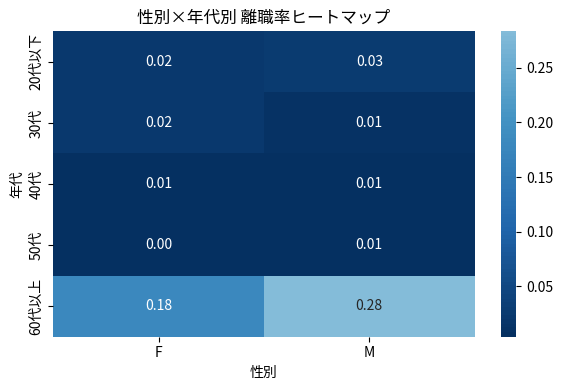

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(pivot_table, annot=True, cmap='RdBu_r', center=0.5, fmt=".2f")
plt.title("性別×年代別 離職率ヒートマップ")
plt.ylabel("年代")
plt.xlabel("性別")
plt.tight_layout()
plt.show()

# 20代以下の女性以下のうち2パーセントが離職。
# 男性の60代以上のうち 28％が離職（かなり高い）